# Computer Vision Face Detection Lab - Student Notebook

In this lab, you will use Amazon Rekognition to perform a facial detection of a known face.

The high-level steps you will perform in this lab are:

1. Create a collection.

2. Upload an image of a face that you want to detect to the Amazon SageMaker notebook.

3. Add the image to the collection.

4. View the bounding box that was created for the image.

5. List the faces in the collection.

6. Use the collection to find a face.

7. View the bounding box of the face that was found.

8. Delete the collection.

---

## Importing Python packages

Start by importing the Python packages that you need.

In the following code:

- *matplotlib* provides plotting functions
- *skimage* represents scikit-image, which provides several useful image manipulation tools
- *boto3* represents the AWS SDK for Python (Boto3), which is the Python library for AWS
- *numpy* represents NumPy, which is a library for manipulating data
- *PIL* represents the Python Imaging Library, which contains a set of tools for drawing images


In [1]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt

import boto3

import numpy as np

from PIL import Image, ImageDraw, ImageColor, ImageOps


## Task 1: Creating a collection

In this task, you create a collection in Amazon Rekognition.

You only need to run this step once.


In [20]:
client = boto3.client('rekognition')
collection_id = 'Collection'
response = client.create_collection(CollectionId=collection_id)
print('Collection ARN: ' + response['CollectionArn'])
print('Status Code:' + str(response['StatusCode']))
print('Done...')

Collection ARN: aws:rekognition:us-east-1:296695592911:collection/Collection
Status Code:200
Done...


## Task 2: Uploading an image to search

Use the provided sample image, which is named *mum.jpg*, and upload it to this notebook.

Then, look at the image by running the cell.


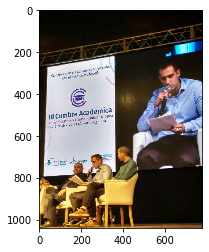

In [21]:
filename = "1.jpg"

faceimage = io.imread(filename)

plt.imshow(faceimage)



Make sure that the image size is less than 4096 x 4096 pixels. If the image is larger than this size, then you must resize it by using the following code:

`faceimage = rescale(faceimage, 0.50, mode='constant')`

**Note:** The numeric value represents the factor to scale by. A value of *0.5* will scale the image to 50 percent of the original.

When the image is resized, save the file.

`io.imsave(filename, faceimage)`

**Tip:** You must copy the code into a code cell and run it.


## Task 3: Adding the image to the collection

Add the image to the collection that you created earlier.


In [22]:
externalimageid = filename

with open(filename, 'rb') as fimage:
    response = client.index_faces(CollectionId = collection_id,
                             Image={'Bytes': fimage.read()},
                             ExternalImageId=externalimageid,
                             MaxFaces=10,
                             QualityFilter="AUTO",
                             DetectionAttributes=['ALL'])

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
     print('  Face ID: ' + faceRecord['Face']['FaceId'])
     print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

print('Faces not indexed:')
for unindexedFace in response['UnindexedFaces']:
    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print(' Reasons:')
    for reason in unindexedFace['Reasons']:
        print('   ' + reason)

Results for 1.jpg
Faces indexed:
  Face ID: 3531f3e1-c444-4101-90e2-5bde2e53c5b6
  Location: {'Width': 0.10779794305562973, 'Height': 0.1066824421286583, 'Left': 0.7330371737480164, 'Top': 0.2633313238620758}
  Face ID: 5be06f97-9a9e-4a8e-9261-b9f1a3e92e7b
  Location: {'Width': 0.05072203278541565, 'Height': 0.0486753024160862, 'Left': 0.210995152592659, 'Top': 0.7031145095825195}
  Face ID: 64a0f474-a962-4c6a-b81f-7e6529df196b
  Location: {'Width': 0.04686983674764633, 'Height': 0.05241839960217476, 'Left': 0.3183986246585846, 'Top': 0.674828827381134}
  Face ID: 4fee38cd-979b-431c-8327-93f52674ad02
  Location: {'Width': 0.033891960978507996, 'Height': 0.05102093145251274, 'Left': 0.47638624906539917, 'Top': 0.641146719455719}
Faces not indexed:


## Task 4: Viewing the bounding box for the detected face

If a face was found, the results should include the location of the face that was detected. Examine the bounding box on the image.

To do this, use the PIL library, which you imported earlier in this lab. By extracting the BoundingBox, you can draw a set of lines around the image.


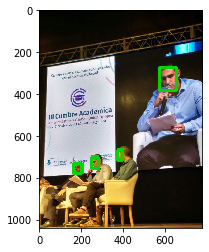

In [23]:
img = Image.open(filename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))

    draw.line(points,fill='#00d400', width=15)
    
plt.imshow(img)

## Task 5: Listing faces in the collection

Examine the image that you have in the collection. 



In [24]:
maxResults=5
faces_count=0
tokens=True

response=client.list_faces(CollectionId=collection_id,
                           MaxResults=maxResults)

print('Faces in collection ' + collection_id)

while tokens:

    faces=response['Faces']

    for face in faces:
        print (face)
        faces_count+=1
    if 'NextToken' in response:
        nextToken=response['NextToken']
        response=client.list_faces(CollectionId=collection_id,
                                   NextToken=nextToken,MaxResults=maxResults)
    else:
        tokens=False

Faces in collection Collection
{'FaceId': '3531f3e1-c444-4101-90e2-5bde2e53c5b6', 'BoundingBox': {'Width': 0.1077980026602745, 'Height': 0.10668200254440308, 'Left': 0.733036994934082, 'Top': 0.26333099603652954}, 'ImageId': 'e73ed7f5-dde4-3300-bc52-8fbf19007fa9', 'ExternalImageId': '1.jpg', 'Confidence': 99.9999008178711}
{'FaceId': '4fee38cd-979b-431c-8327-93f52674ad02', 'BoundingBox': {'Width': 0.03389199823141098, 'Height': 0.05102090165019035, 'Left': 0.47638601064682007, 'Top': 0.6411470174789429}, 'ImageId': 'e73ed7f5-dde4-3300-bc52-8fbf19007fa9', 'ExternalImageId': '1.jpg', 'Confidence': 98.8938980102539}
{'FaceId': '5be06f97-9a9e-4a8e-9261-b9f1a3e92e7b', 'BoundingBox': {'Width': 0.05072199925780296, 'Height': 0.0486752986907959, 'Left': 0.21099500358104706, 'Top': 0.7031149864196777}, 'ImageId': 'e73ed7f5-dde4-3300-bc52-8fbf19007fa9', 'ExternalImageId': '1.jpg', 'Confidence': 99.99129486083984}
{'FaceId': '64a0f474-a962-4c6a-b81f-7e6529df196b', 'BoundingBox': {'Width': 0.04686

## Task 6: Finding a face by using the collection

In this step, you will use the collection to detect a face in an image.

Use the provided sample image that's named *target.jpg* and upload it to this notebook.



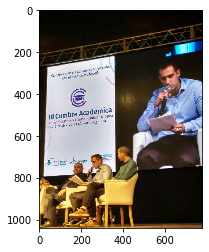

In [25]:
targetfilename = "1.jpg"

targetimage = Image.open(targetfilename)
plt.imshow(targetimage)

Next, call the `search_faces_by_image` operation and see if you get a match.

In [26]:
threshold = 70
maxFaces=10

with open(targetfilename, 'rb') as timage:        
    response2=client.search_faces_by_image(CollectionId=collection_id,
                            Image={'Bytes': timage.read()},
                            FaceMatchThreshold=threshold,
                            MaxFaces=maxFaces)

faceMatches=response2['FaceMatches']
print ('Matching faces')
for match in faceMatches:
        print ('FaceId:' + match['Face']['FaceId'])
        print ('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
        print ('ExternalImageId: ' + match['Face']['ExternalImageId'])
        print

Matching faces
FaceId:3531f3e1-c444-4101-90e2-5bde2e53c5b6
Similarity: 100.00%
ExternalImageId: 1.jpg
FaceId:64a0f474-a962-4c6a-b81f-7e6529df196b
Similarity: 99.94%
ExternalImageId: 1.jpg


## Task 7: Drawing a bounding box around the discovered face

Draw a bounding box around the discovered face.

In [33]:
response2

{'SearchedFaceBoundingBox': {'Width': 0.10779794305562973,
  'Height': 0.1066824421286583,
  'Left': 0.7330371737480164,
  'Top': 0.2633313238620758},
 'SearchedFaceConfidence': 99.99991607666016,
 'FaceMatches': [{'Similarity': 100.0,
   'Face': {'FaceId': '3531f3e1-c444-4101-90e2-5bde2e53c5b6',
    'BoundingBox': {'Width': 0.1077980026602745,
     'Height': 0.10668200254440308,
     'Left': 0.733036994934082,
     'Top': 0.26333099603652954},
    'ImageId': 'e73ed7f5-dde4-3300-bc52-8fbf19007fa9',
    'ExternalImageId': '1.jpg',
    'Confidence': 99.9999008178711}},
  {'Similarity': 99.94454956054688,
   'Face': {'FaceId': '64a0f474-a962-4c6a-b81f-7e6529df196b',
    'BoundingBox': {'Width': 0.04686979949474335,
     'Height': 0.05241839960217476,
     'Left': 0.31839901208877563,
     'Top': 0.6748290061950684},
    'ImageId': 'e73ed7f5-dde4-3300-bc52-8fbf19007fa9',
    'ExternalImageId': '1.jpg',
    'Confidence': 99.99169921875}}],
 'FaceModelVersion': '5.0',
 'ResponseMetadata': {'

In [44]:
response2['FaceMatches'][1]['Face']['BoundingBox']

{'Width': 0.04686979949474335,
 'Height': 0.05241839960217476,
 'Left': 0.31839901208877563,
 'Top': 0.6748290061950684}

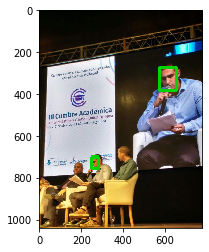

In [45]:
imgWidth, imgHeight = targetimage.size

draw = ImageDraw.Draw(targetimage)
for array in response2['FaceMatches']:
    box = array['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))
    draw.line(points,fill='#00d400', width=15)
    
    plt.imshow(targetimage)

## Task 8: Deleting the collection

When you are finished, delete the collection. To do this, run the following code. 


In [17]:
print('Attempting to delete collection ' + collection_id)
status_code=0
try:
    response=client.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('All done!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('The collection ' + collection_id + ' was not found ')
    else:
        print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']



Attempting to delete collection Collection
All done!
200


# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.